<a href="https://colab.research.google.com/github/mixa15341/Deep_Learning/blob/main/8.%20%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE-%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F%20%D1%81%D0%B5%D1%82%D1%8C%20(GAN)/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%968_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%BE_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D1%81%D0%B5%D1%82%D1%8C_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Генеративно-состязательная сеть (GAN)**

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример №1](https://www.kaggle.com/datasets/andrewmvd/medical-mnist), [Пример №2](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data#example), [Пример №3](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))





In [96]:
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np

In [90]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

In [91]:
def build_generator():
    # Вектор случайного шума, используемый в качестве входного слоя для Генератора:
    noise_shape = (100,) # 1D массив размером 100 (латентный вектор / шум)

    model = Sequential()

    #Alpha - α - это гиперпараметр, который управляет базовым значением, на который функция
    # функция домножает отрицательные входы сети.
    #Momentum - «задержка» в обучении среднего значения и дисперсии, поэтому шум из-за мини-пакета можно игнорировать
    # Ссылка: https://medium.com/@ilango100/batchnorm-fine-tune-your-booster-bef9f9493e22

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    # Генерация изображения

    return Model(noise, img)


In [92]:

def build_discriminator():


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)  # предположение дискриминатора о том, является ли входное изображение реальным или нет.

    return Model(img, validity)

In [94]:

from keras.models import load_model, save_model

def save(gan, generator, discriminator):
    root_path = ''
    discriminator.trainable = False
    save_model(gan, root_path+'gan')
    discriminator.trainable = True
    save_model(generator, root_path + 'generator')
    save_model(discriminator, root_path + 'discriminator')

In [95]:

def load():
    root_path = ''
    discriminator = load_model(root_path + 'discriminator')
    generator = load_model(root_path + 'generator')
    gan = load_model(root_path + 'gan')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [97]:
def train(epochs, batch_size=128, save_interval=50):

    # Загружаем набор данных
    (X_train, _), (_, _) = fashion_mnist.load_data()

    # Преобразование в тип float и нормализация от -1 до 1 (можно также от 0 до 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    #Добавляем размерность каналов. В качестве входных данных для наших gen и discr. имеет форму 28x28x1.
    X_train = np.expand_dims(X_train, axis=3)
    half_batch = int(batch_size / 2)


    # Обучаем Дискриминатор,
    # выбираем случайную партию изображений из нашего истинного набора данных,
    # генерируем набор изображений с помощью Генератора, затем подаём оба набора изображений в наш Дискриминатор,
    # и, наконец, вычисляем параметры функции потерь для реальных и сгенерированных
    #  (поддельных) изображений, а также комбинированные потери.

    for epoch in range(epochs):

        # ---------------------
        #  Обучение Дискриминатора
        # ---------------------

        # Выберите случайную половину партии реальных изображений
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]


        noise = np.random.normal(0, 1, (half_batch, 100))

        # Сгенерируем половину партии поддельных изображений
        gen_imgs = generator.predict(noise)

        # Обучение дискриминатора на реальных и поддельных изображениях отдельно.
        # Исследования показали, что раздельное обучение более эффективно.
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Процесс обучения происходит с помощью метода train_on_batch()
        # Метод `train_on_batch` обновляет веса модели на основе одной партии данных,
        # в отличие от метода `fit`, который использует весь набор данных для обучения.
        # Это делает `train_on_batch` идеальным для обучения на больших наборах
        # данных или для реализации более сложных процедур обучения.
        # Ссылка:https://keras.io/api/models/model_training_apis/

        # Вычисление средней потери от реальных и поддельных изображений.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #И в том же цикле мы обучаем наш Генератор, задавая входной шум
        # и в конечном итоге обучая Генератор тому, чтобы Дискриминатор
        # помечал его образцы как достоверные задавая градиентные потери.

        # ---------------------
        #  Обучение Генератора
        # ---------------------

        #Создаём векторы случайного шума в качестве входных данных для генератора.
        # На каждую партию необходимо создать свой вектор.
        # Шум основано на нормальном распределении (от 0 до 1).
        # Выходные данные будут иметь размер (размер партии, 100)

        noise = np.random.normal(0, 1, (batch_size, 100))

        # Генератору необходимо добиться того, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (1)
        # Здесь генератор пытается "обмануть" дискриминатор, чтобы тот "поверил", в то
        # что сгенерированный образ является истинным (отсюда значение 1 для y)
        valid_y = np.array([1] * batch_size) #Создает массив всех единиц размера size=batch size

        # Генератор является частью комбинированной системы, где он напрямую связан с дискриминатором.
        # Обучим генератор, используя шум в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он состязательный,
        # и если генератор отлично справился со своей р работой по следованию дискриминатору, то на выходе будет 1 (истина).

        g_loss = combined.train_on_batch(noise, valid_y)


#Дополнительно, чтобы мы могли отслеживать процесс обучения, мы выводим на печать
# прогресс и сохраняем вывод образцов изображений в зависимости от заданного интервала эпох,
# а также по желанию, можем сохранять модель.

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # Если в интервале сохранения => сохраняем сгенерированные образцы изображений
        if epoch % save_interval == 0:
            save_imgs(epoch)
            if epoch % 1000 == 0:
                # save(combined, generator, discriminator)
                save(combined, generator, discriminator)

In [98]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [99]:
# Определим наш оптимизатор для удобства использования в дальнейшем.
optimizer = Adam(0.0002, 0.5)  #Скорость обучения и экспоненциальная скорость затухания для оценок первого момента.

In [100]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [101]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_9 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_10 (Ba  (None, 512)               2048      
 tchNormalization)                                    

In [102]:
z = Input(shape=(100,))
img = generator(z)

In [103]:
discriminator.trainable = False

In [104]:
valid = discriminator(img)  #Проверка достоверности сгенерированного изображения

In [105]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

In [106]:
train(epochs=25000, batch_size=32, save_interval=1000)

generator.save('generator_model_final.h5')

Выходные данные были обрезаны до нескольких последних строк (5000).
1/1 [==============================] - 0s 21ms/step
22501 [D loss: 0.627684, acc.: 65.62%] [G loss: 0.832976]
1/1 [==============================] - 0s 19ms/step
22502 [D loss: 0.758315, acc.: 50.00%] [G loss: 0.792654]
1/1 [==============================] - 0s 18ms/step
22503 [D loss: 0.745979, acc.: 53.12%] [G loss: 0.781736]
1/1 [==============================] - 0s 17ms/step
22504 [D loss: 0.633538, acc.: 68.75%] [G loss: 0.766105]
1/1 [==============================] - 0s 20ms/step
22505 [D loss: 0.676812, acc.: 59.38%] [G loss: 0.759608]
1/1 [==============================] - 0s 18ms/step
22506 [D loss: 0.618792, acc.: 68.75%] [G loss: 0.811012]
1/1 [==============================] - 0s 18ms/step
22507 [D loss: 0.686491, acc.: 50.00%] [G loss: 0.772622]
1/1 [==============================] - 0s 18ms/step
22508 [D loss: 0.603149, acc.: 68.75%] [G loss: 0.764552]
1/1 [==============================] - 0s 17ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Демонстрация сгенерированных изображений:

1/1 [==============================] - 0s 17ms/step


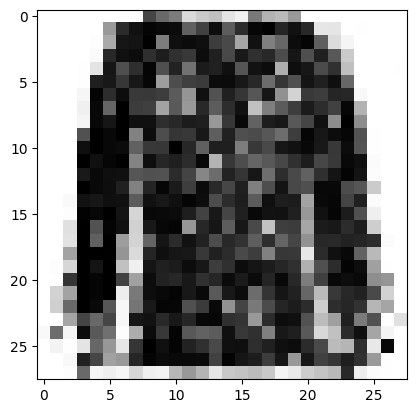

In [111]:
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

# model = load_model('generator_model_final.h5')
model = generator

# Чтобы создать одинаковое изображение, каждый раз подавайте один и тот же вектор.

#Для создания случайных изображений каждый раз...
vector = randn(100) #Вектор случайных чисел (создает столбец, необходимо изменить форму)
vector = vector.reshape(1, 100)

# сгенеруем изображение
X = model.predict(vector)

# Выведем результат
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()

In [112]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

In [113]:

def generate_latent_points(latent_dim, n_samples):
  # генерируем случайные вектора по количеству n_samples
	x_input = randn(latent_dim * n_samples)
	# переформировать в пакет входных данных для сети
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [114]:
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

1/1 [==============================] - 0s 31ms/step


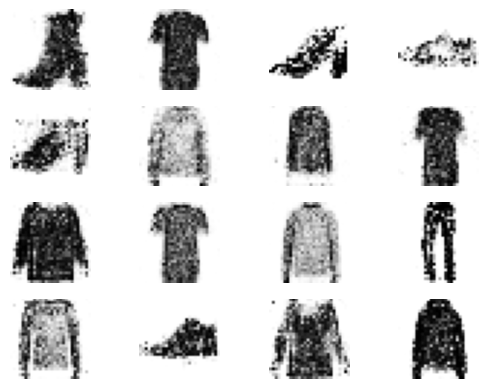

In [115]:
# model = load_model('generator_model_final.h5')
model = generator


# Сгенерируем 16 векторов случайного шума
latent_points = generate_latent_points(100, 16)

# Генерируем изображения га основе сгенерированных векторов
X = model.predict(latent_points)

# Выводим результаты
save_plot(X, 4)  # Таблица 4x4 (Можно изменить на 5 для генерации и вывода 25 изображений)

# **Задание №2.** Обучите генератор воспризводить примитивные изображения по заданному условию (Conditional Generative Adversarial Nets (CGAN)).

(На вход генератора подается вектор случайного шума и метка класса - на выходе должно получиться изображение, соответствующее данному классу)

Датасет выберите по желанию. ([Пример №1](https://www.kaggle.com/datasets/andrewmvd/medical-mnist), [Пример №2](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data#example), [Пример №3](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [107]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

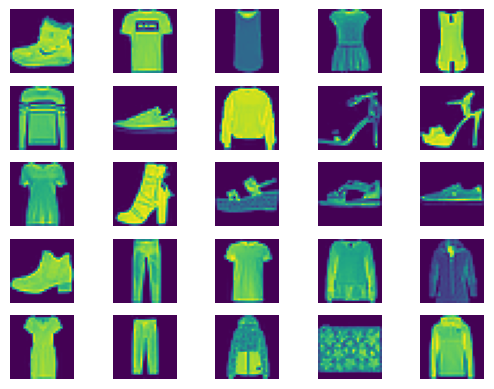

(60000, 28, 28)

In [130]:

(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()
trainX.shape

In [117]:
def define_discriminator(in_shape=(32,32,3), n_classes=10):

    # Входная метка класса
	in_label = Input(shape=(1,))
    #Каждая метка (всего 10 классов для cifar) будет представлена вектором размера 50.
    #Этот вектор размера 50 будет изучаться дискриминатором.
	li = Embedding(n_classes, 50)(in_label) #Shape = 1,50 (https://keras.io/api/layers/core_layers/embedding/)
	# масштабирование до размеров изображения
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024.
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# изменим форму с добавлением канала
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# Входное изображение
	in_image = Input(shape=in_shape) #32x32x3
  # Добавляем метку кDense(n_nodes)ласса в качестве последнего канала
	merge = Concatenate()([in_image, li]) #32x32x4 (4 канала, 3 для изображения и четвертый для метки класса)

	# понижение дискретизации: Эта часть аналогична GAN из прошлой работы до выходного слоя.
  #Мы объединим входную метку с входным изображением и подадим их на вход модели.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# понижение дискретизации
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# выровненная карта признаков
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# Комбинируем входную метку с входным изображением и подаем в качестве входных данных в модель.
	model = Model([in_image, in_label], out_layer)
	# Компилируем модель
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

test_discr = define_discriminator()
print(test_discr.summary())

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_13[0][0]']            
                                                                                                  
 dense_28 (Dense)            (None, 1, 1024)              52224     ['embedding[0][0]']           
                                                                                                  
 input_14 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                           

In [118]:
def define_generator(latent_dim, n_classes=10):

	# Входная метка класса
	in_label = Input(shape=(1,))  #Вход размерности 1
	#Каждая метка (всего 10 классов для cifar), будет представлена вектором размером 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# линейное умножение
	n_nodes = 8 * 8  # Чтобы сопоставить размеры для конкатенации позже
	li = Dense(n_nodes)(li) #1,64
	# изменим форму с добавлением канала
	li = Reshape((8, 8, 1))(li)


	# входной слой генератора изображений
	in_lat = Input(shape=(latent_dim,))  #Вход размером 100

	# Пусть базовое изображение будет иметь размерность 8x8
    # Для этого необходимо преобразовать входной латентный вектор в изображение 8x8.
    #Таким образом, значение n_nodes для полносвязного слоя может быть 8192 (128*8*8)
    # это позволит нам преобразовать его в "изображение" с размерностью 8x8x128
    # которое мы постепенно будем "увеличивать" до размерности 32x32х3 для вывода.
    #При определении входов модели мы объединим входную метку и латентный вход.

	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# объединяем входные данные изображения и соответствующей ему метки класса
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Дополнительный канал соответствующий метке класса)
	# увеличиваем дискретизацию до 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# увеличиваем дискретизацию до to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# Выходной слой
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
  # определяем модель
	model = Model([in_lat, in_label], out_layer)
	return model   #Модель не компилируется, поскольку она не обучается напрямую, как дискриминатор.

test_gen = define_generator(100, n_classes=10)
print(test_gen.summary())

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_31 (Dense)            (None, 8192)                 827392    ['input_16[0][0]']            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_15[0][0]']            
                                                                                           

In [119]:
def define_gan(g_model, d_model):
  d_model.trainable = False  # Дискриминатор обучается отдельно, поэтому делаем его необучаемым.

    ## соединяем генератор и дискриминатор
	# сначала получаем входные данные - вектор шума и метки из модели генератора
  gen_noise, gen_label = g_model.input
	# получение выходного изображения из модели генератора
  gen_output = g_model.output  #32x32x3

  # выходное изображение генератора и соответствующая входная метка являются входами для дискриминатора
  gan_output = d_model([gen_output, gen_label])
	# определим gan-модель как модель принимающую на вход вектор шума и метку класса (для генератора), и выдающую значение классификатора дискриминатора
  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [208]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
def load_real_samples():
  (trainX, trainy), (_, _) = fashion_mnist.load_data()
  trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
  X = np.repeat(trainX, 3, axis=3)
  X = X.resize(X, [32, 32])
  X = (X - 127.5) / 127.5
  return [X, trainy]

In [121]:
def generate_real_samples(dataset, n_samples):
	# разделяем изображения и метки
  images, labels = dataset
	# выбираем случайные экземпляры
  ix = randint(0, images.shape[0], n_samples)
	# выбераем изображения и метки
  X, labels = images[ix], labels[ix]
  # генерируем метки классов и присваиваем их переменной y
  #  (не путайте с вышеуказанными метками, которые соответствуют меткам cifar)
  y = ones((n_samples, 1))  #Label=1 идентифицирует о том, что изображение реальное
  return [X, labels], y

In [122]:
# Для генерации случайного шума используется функция, описанная выше
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))  #Label=0 указывает на то, что они поддельные
	return [images, labels_input], y

In [123]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [124]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #модель дискриминатора обновляется для половины партии реальных образцов
                            #и половины партии поддельных образцов, объединенных в одну партию.
	for i in range(n_epochs):
		for j in range(bat_per_epo):

      # Обучаем дискриминатор на реальных и поддельных изображениях, отдельно (по половине партии каждого).
      # Исследования показали, что раздельное обучение более эффективно.

			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

      # обновление весов модели дискриминатора
      # train_on_batch позволяет обновлять веса на основе коллекции предоставляемых образцов

			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

			# генерируем поддельные примеры
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# обновляем веса модели дискриминатора
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)


			# генерация вектором случайного шума для нужного числа экземпляров в качестве входных данных для генератора
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

        # Генератор хочет, чтобы дискриминатор пометил сгенерированные образцы
        # как истинные (единицы)
        # Здесь генератор пытается обмануть дискриминатор, чтобы тот поверил.
        # что сгенерированное изображение истинно (отсюда значение 1 для y)
			  # поэтому для поддельных образцов мы создаём инвертированные метки
			y_gan = ones((n_batch, 1))

        # Генератор является частью комбинированной модели, где он напрямую связан с дискриминатором.
        # Обучите генератор с latent_dim в качестве x и 1 в качестве y.
        # Опять же, 1 в качестве выхода, так как он является состязательным, и если генератор отлично справился со своей задачей.
        # работу по следованию дискриминатору, то на выходе будет 1 (true)
			  # обновить генератор через ошибку дискриминатора

			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Выводим потери по этой партии
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))

In [128]:
trainX.shape

(60000, 28, 28)

In [209]:
# Размерность вектора случайного шума
latent_dim = 100
# создание модели дискриминатора
d_model = define_discriminator()
# создание модели генератора
g_model = define_generator(latent_dim)
# создание комбинированной модели GAN
gan_model = define_gan(g_model, d_model)
# загрузка датасета
dataset = load_real_samples()
# обучение модели
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=25)

# сохранение обученной модели генератора (без возможности дообучения)
g_model.save('fashion_mnist_conditional_generator_25epochs.h5')

TypeError: only integer scalar arrays can be converted to a scalar index

### Демонстрация сгенерированных изображений:

In [ ]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

In [ ]:
model = load_model('/content/fashion_mnist_conditional_generator_25epochs.h5')

In [ ]:
# генерируем набор случайных векторов и меток классов
latent_points, labels = generate_latent_points(100, 100)

# задаём метки классов - генерируем 10 наборов меток,
# каждая из которых имеет значение от 0 до 9
labels = asarray([x for _ in range(10) for x in range(10)])

# Генерируем изображения
X  = model.predict([latent_points, labels])

# Преобразуем значения каждого пикселя в диапазон [0, 255] из диапазона [-1,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

# Выводим сгенерированные изображения (По 10 изображений для каждого класса)
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.savefig('fashion_mnist_generate.png', dpi = 300)
	plt.show()

show_plot(X, 10)

In [ ]:
from IPython.display import Image
Image('/content/fashion_mnist_conditional_generator_877.png')

# **Задание №3.** Обучите генератор воспризводить **спутниковый снимок** по **загруженной маске** (pix2pix). Используйте для этого разделенный на патчи  [датасет](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery)

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from keras.utils import plot_model

In [ ]:
def define_discriminator(image_shape):

	# инициализация веса
	init = RandomNormal(stddev=0.02) # Как описано в оригинальной статье

	# Входной слой для исходного изображения
	in_src_image = Input(shape=image_shape)  # Изображение, которое мы хотим преобразовать в другое изображение
       # Входной слой для целевого изображения
	in_target_image = Input(shape=image_shape)  # Изображение, которое мы хотим получить после обучения.

       # конкатенируем изображения по каналам
	merged = Concatenate()([in_src_image, in_target_image])

	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2. Этот блок кода добавлен самостоятельно, его нет в оригинальной статье. Закомментируйте его, если хотите.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# последний выходной слой: 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# формирование патча
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# определяем модель
	model = Model([in_src_image, in_target_image], patch_out)

   #Модель обучается с размером партии в одно изображение, оптимизатором Adam с небольшой скоростью обучения и значением beta = 0.5.
    # Устанавливаем весовой коэффициент для дискриминатора в 50% (0.5) .

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)


In [ ]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
       # добавим слой понижающей дискретизации
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
      # добавим опционально нормализацию батчей
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [ ]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# инициализируем вес
	init = RandomNormal(stddev=0.02)
	# добавим слой повышающей дискретизации
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# добавим нормализацию батчей
	g = BatchNormalization()(g, training=True)
	# опционально добавим дропаут
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# объединяем с пропуском соединения (skip connection)
	g = Concatenate()([g, skip_in])
	g = Activation('relu')(g)
	return g

In [ ]:
def define_generator(image_shape=(256,256,3)):
	# инициализация веса
	init = RandomNormal(stddev=0.02)
	# входной слой для изображения
	in_image = Input(shape=image_shape)
	# Архитектура энкодера: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# Архитектура декодера: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# Выходной слой
	g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)  #Генерируется изображение в диапазоне от -1 до 1.
	# Определяем модель
	model = Model(in_image, out_image)
	return model

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [ ]:
# определяем комбинированную модель генератора и дискриминатора, для обновления генератора
def define_gan(g_model, d_model, image_shape):
	# делаем веса в дискриминаторе не обучаемыми
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False       #Слои дескриминатора установлены на необучаемые в комбинированной GAN, но
                                                # отдельный дескриминатор будет обучаемым.

	# определим входной слой для исходного изображения
	in_src = Input(shape=image_shape)
	# подаём изображение на вход генератора
	gen_out = g_model(in_src)
	# подаём входное изображения и сформированного изображения в качестве входных данных в дискриминатор
	dis_out = d_model([in_src, gen_out])
	# входное изображение в качестве входа, сгенерированное изображение и значение выходного слоя дискриминатора в качестве выходов
	model = Model(in_src, [dis_out, gen_out])
	opt = Adam(lr=0.0002, beta_1=0.5)

    #Общая потеря - это взвешенная сумма потерь от “состязательности” (Бинарная кросс-энтропия) и потери от MAE (L1).
    #Авторы предложили взвесить соотношение BCE и MAE как 1:100.
	model.compile(loss=['binary_crossentropy', 'mae'],
               optimizer=opt, loss_weights=[1,100])
	return model

In [ ]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# распаковка набора данных
	trainA, trainB = dataset
	# выбор случайных экземпляры
	ix = randint(0, trainA.shape[0], n_samples)
	# извлечение выбранных изображений
	X1, X2 = trainA[ix], trainB[ix]
	# генерация "реальных" меток классов (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y


In [ ]:
def generate_fake_samples(g_model, samples, patch_shape):
	X = g_model.predict(samples)
	# генерация "поддельных" меток классов (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# формирование выборки входных изображений
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# генерация партии поддельных изображений
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# Нормализация
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])

	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])

	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# определение размерности выходного значения дискриминатора
	n_patch = d_model.output_shape[1]
	# распаковка датасета
	trainA, trainB = dataset
	# вычисление количества партий на одну эпоху обучения
	bat_per_epo = int(len(trainA) / n_batch)
	# вычисление количества тренировочных итераций
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
 		# формирование партии обучающей выборки (реальных образцов)
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# генерация партии поддельных образцов
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# обучение дискриминатора на реальных образцах
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# обучение дискриминатора на «поддельных» образцах
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# обучение генератора
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# индикация процесса обучения
		print(f'Эпоха: {((i+1) // bat_per_epo) + 1}')
		print('Итерация: %d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		if (i+1) % (bat_per_epo * 1) == 0: # Сохраняем модель генератора и набор изображений каждую (1) эпоху.
			summarize_performance(i, g_model, dataset)

### Демонстрация сгенерированных изображений:

In [ ]:
# Ваш код

# **Задание №4.** Обучите генератор воспроизводить изображения из выбранного Вами датасета (pix2pix).

### Датасет может быть сформирован Вами (например, черно-белые и цветные изображения) или найден в глобальной сети Интернет.

#### Например [тут](https://www.kaggle.com/search?q=pix2pix+in%3Adatasets+datasetFileTypes%3Ajpg+datasetFileTypes%3Apng) или [тут](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/)

In [ ]:
# Ваш код

### Демонстрация сгенерированных изображений:

In [ ]:
# Ваш код